In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import struct

import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int32)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [3]:
X_train, y_train = read_hoda_dataset(dataset_path='./DigitDB/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)
 
X_test, y_test = read_hoda_dataset(dataset_path='./DigitDB/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

X_remaining, y_remaining = read_hoda_dataset(dataset_path='./DigitDB/RemainingSamples.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

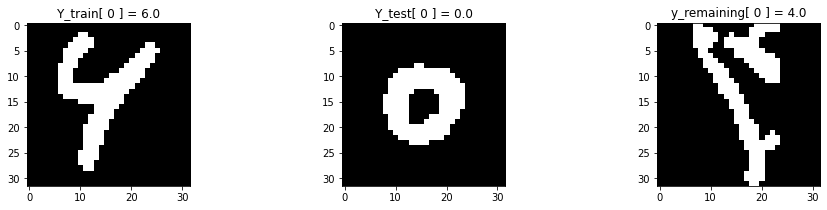

In [4]:


fig = plt.figure(figsize=(16, 3))
fig.add_subplot(1, 3, 1)
plt.title('Y_train[ 0 ] = ' + str(y_train[0]))
plt.imshow(X_train[0].reshape([32, 32]), cmap='gray')

fig.add_subplot(1, 3, 2)
plt.title('Y_test[ 0 ] = ' + str(y_test[0]))
plt.imshow(X_test[0].reshape([32, 32]), cmap='gray')

fig.add_subplot(1, 3, 3)
plt.title('y_remaining[ 0 ] = ' + str(y_remaining[0]))
plt.imshow(X_remaining[0].reshape([32, 32]), cmap='gray')

plt.show()



In [5]:
X_train_flattened = X_train.reshape(len(X_train), 32*32)
X_test_flattened = X_test.reshape(len(X_test), 32*32)

X_train_flattened.shape

(60000, 1024)

In [6]:
from sklearn.preprocessing import MinMaxScaler

class MDC():
    def __init__(self):
        self.w={}
    def distance(self,a,b):
        return np.sqrt(sum((a-b)**2))
    def fit(self,X,y):
        scaler = MinMaxScaler()
        x_scaled=scaler.fit_transform(X)    
        classes=np.unique(y)
        for label in classes:
            a=x_scaled[y==label]
            self.w[label]=np.mean(a,axis=0)
    def predict(self,X):
        y=np.array([])
        scaler =MinMaxScaler()
        x_scaled=scaler.fit_transform(X) 
        for sample in x_scaled:
            v={}
            for i in self.w:
                v[i]=self.distance(self.w[i],sample)
            y=np.append(y,min(v,key=v.get))
        return y
    def pred(self,X):
   
        v={}
        for i in self.w:
            v[i]=self.distance(self.w[i],X)
            y=min(v,key=v.get)
        return y


In [7]:
c=MDC()
c.fit(X_train_flattened,y_train)

In [8]:
y_pred=c.predict(X_test_flattened)

In [10]:
np.sum(y_pred==y_test)/y_test.shape[0]

0.73695

In [29]:
X_test_false=X_test[~(y_pred==y_test)]
y_test_false=y_pred[~(y_pred==y_test)]
y_test_true=y_test[~(y_pred==y_test)]
ind=np.random.choice(X_test_false.shape[0],5)
y_test_sample=y_test_false[ind]
X_test_sample=X_test_false[ind]

In [26]:
X_test_false.shape

(5261, 1024)

In [27]:
y_test_sample

array([1., 6., 2., 8., 7.])

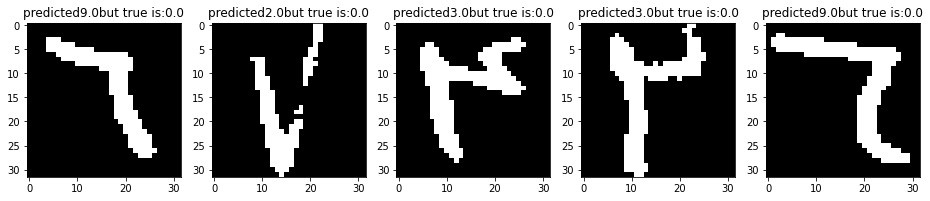

In [32]:
fig = plt.figure(figsize=(16, X_test_sample.shape[0]))

for i in range(X_test_sample.shape[0]):
    fig.add_subplot(1,X_test_sample.shape[0], i+1)
    plt.title('predicted' + str(y_test_sample[i])+'but true is:'+str(y_test_true[i]))
    plt.imshow(X_test_sample[i].reshape([32, 32]), cmap='gray')
